In [74]:
γr, kr, γp, kp = 1/5,1,1/45,50

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import jit,njit,float64,int32
import numba as nb

In [76]:
@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    t,r,p =trp0 

    while t < tmax:
        s1 = kr
        s2 = γr*r
        s3 = kp*r
        s4 = γp*p
        st = s1+s2+s3+s4
        τ = (-1/st)*np.log(np.random.rand())
        x = np.random.rand()
        if(x< s1/st):
            r+=1
        elif(x<(s1+s2)/st):
            r-=1
        elif(x<(s1+s2+s3)/st):
            p+=1
        else:
            p-=1
        t+=τ
    return np.array([t,r,p]) 

In [77]:
@njit('f8[:,:](f8[:],f8[:])')
def Estado_celula(X0,tiempos):
    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
    
    return X

In [78]:
x0 = np.array([0.,0.,0.])

In [79]:
una_celula = Estado_celula(x0,np.linspace(0,50))

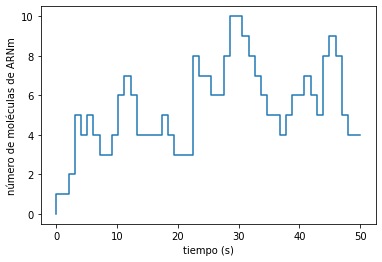

In [80]:
plt.xlabel('tiempo (s)')
plt.ylabel('número de moléculas de ARNm')
plt.step(una_celula[:,0],una_celula[:,1])

In [81]:
num_cel = 100 #número de células 
celulas = np.array([Estado_celula(x0,np.arange(0.,700.,2.)) for i in range(num_cel)])
celulas.shape

(100, 350, 3)

In [82]:
celulas_prom = np.mean(celulas,axis=0)
print(x0)

[0. 0. 0.]


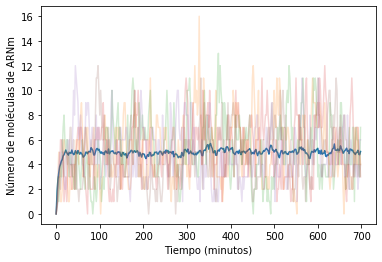

In [83]:
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Número de moléculas de ARNm')
plt.plot(celulas_prom[:,0],celulas_prom[:,1])
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,1],alpha=0.2)

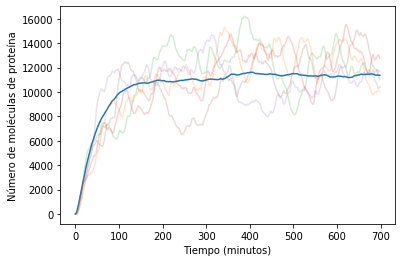

In [84]:
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Número de moléculas de proteína')
plt.plot(celulas_prom[:,0],celulas_prom[:,2])
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,2],alpha=0.2)

In [85]:
from random import choices, expovariate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
class Gillespie():
    def __init__(self, propensityFuncs, actionFuncs, parameters=None):
        self.propensityFuncs = propensityFuncs
        self.actionFuncs = actionFuncs
        self.parameters = parameters
    def run(self, u0, tend, tstart=0):
        # Setup
        t = tstart
        p = self.parameters
        u = np.asarray(u0)
        us = [u.copy()]
        ts = [t]
        while t < tend:
            # propensities of reactions
            ps = [f(u, p, t) for f in self.propensityFuncs]
            pTotal = sum(ps)
            dt = expovariate(pTotal)
            # Choose an action by the weight of each propensities, and update the state variable
            act = choices(actionFuncs, weights=ps)[0]
            u = np.asarray(act(u, p, t))
            t += dt
            us.append(u.copy())
            ts.append(t)
        return np.array(ts), np.array(us)

In [87]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [88]:
def velocidad_producto(S):
    return vmax * S / (Km + S)

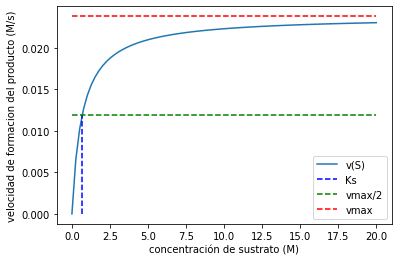

In [89]:
# simular 
Km = 6.75e-1
vmax = 2.38e-2
# valores de sustrato 
S = np.linspace(0, 20, 80)

plt.plot(S, velocidad_producto(S))
plt.plot([Km, Km], [0, 0.0119], "b--")
plt.plot(S, np.ones_like(S) * vmax / 2, "g--")
plt.plot(S, np.ones_like(S)*vmax, "r--")
plt.xlabel("concentración de sustrato (M)")
plt.ylabel("velocidad de formacion del producto (M/s)")
plt.legend(["v(S)", "Ks", "vmax/2", "vmax"])

In [96]:
proteina=celulas_prom[:,2]
# establecer modelo 
def modelo(s, t):
    # variables de estado
    S = s[0]
    ES = s[1]
    E = s[2]
    P = s[3]

    # balance para S
    dSdt = -k1*E*S + kin*ES
    # balance para el comlejo ES
    dESdt = k1*E*S - kin*ES - k2*ES
    # balance para E
    dEdt = - dESdt
    # balance para P 
    dPdt = k2*ES
    return [dSdt, dESdt, dEdt, dPdt]

In [97]:
# establecer parametros 
k1, kin, k2 = 2.3e-2, 1.3e-2, 8.0e-1
# condiciones iniciales (S = 10, ES = 0, E = 1,P = 0) 
s =[10, 0, 1, 0]
# tiempo de integracion
time = np.linspace(0, 100,80 )


In [109]:
TimeN=celulas_prom[:,0]
time=TimeN

out = odeint(modelo, s, time)
S = out[:, 0]
ES = out[:, 1]
E = out[:, 2]
P = out[:, 3]


Text(0, 0.5, 'concentracion (M) del producto (FAME)')

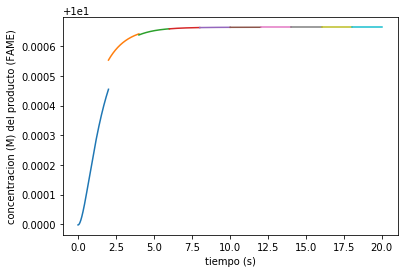

In [110]:

#Número de intervalos
n=len(celulas_prom[:,2])
T_inicial=0
T_final=700
T_partido=np.linspace(T_inicial,T_final,n)

#Número de puntos por intervalo
m=1000

Tiempos_intervalos=[]

for i in range(n-1):
    Intervalo=np.linspace(T_partido[i],T_partido[i+1],m)
    Tiempos_intervalos.append(Intervalo)


CS=celulas_prom[:,2]
ES=ES

E=np.zeros(len(CS)-1)

for i in range(len(E)):
    E[i]=CS[i+1]-ES[i+1]

OUT=[]

for i in range(len(E)):
    s=[S[i], ES[i], E[i], P[i]]
    out = odeint(modelo, s, Tiempos_intervalos[i])
    OUT.append(out)

plt.figure()
for i in range(10):
    time=Tiempos_intervalos[i]
    S=OUT[i][:,3]
    plt.plot(time,S)
    
plt.xlabel("tiempo (s)")
plt.ylabel("concentracion (M) del producto (FAME)")

Text(0, 0.5, 'concentracion (M) de CALA libre')

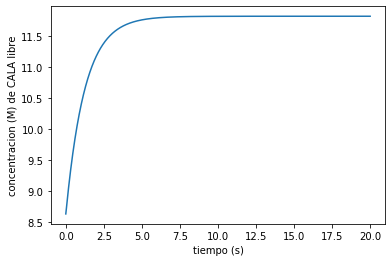

In [94]:
#Número de intervalos
n=len(celulas_prom[:,2])
T_inicial=0
T_final=700
T_partido=np.linspace(T_inicial,T_final,n)

#Número de puntos por intervalo
m=1000

Tiempos_intervalos=[]

for i in range(n-1):
    Intervalo=np.linspace(T_partido[i],T_partido[i+1],m)
    Tiempos_intervalos.append(Intervalo)


CS=celulas_prom[:,2]
ES=ES


E=np.zeros(len(CS)-1)

for i in range(len(E)):
    E[i]=CS[i+1]-ES[i+1]

OUT=[]

#for i in range(len(E)):
#    s=[10, 0, E[0], 0]
#    out = odeint(modelo, s, Tiempos_intervalos[i])
#    OUT.append(out)

#plt.figure()
#for i in range(10):
#  time=Tiempos_intervalos[i]
#  S=OUT[i][:,0]
#  plt.plot(time,S)


#2

#Número de intervalos
n=len(celulas_prom[:,2])
T_inicial=0
T_final=20

#Número de puntos en el tiempo
m=1000

#Cálculo de E
CS=celulas_prom[:,2]
ES=ES


E=np.zeros(len(CS))

for i in range(len(E)):
    E[i]=CS[i]-ES[i]



T=np.linspace(T_inicial,T_final,m)

for i in range(len(E)):
    s=[S[i], ES[i], E[i], P[i]]
    out = odeint(modelo, s, T)
    OUT.append(out)

plt.figure()
plt.plot(T,OUT[50][:,3])
plt.xlabel("tiempo (s)")
plt.ylabel("concentracion (M) de CALA libre")


ValueError: x and y must have same first dimension, but have shapes (100,) and (1000,)

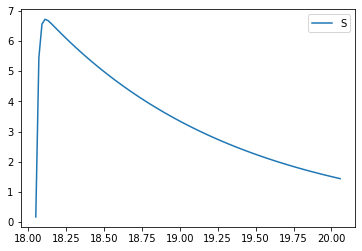

In [22]:
plt.plot(time, S)
plt.legend(["S"])
for  i in range(1,10):
    out=OUT[i]
    SS=out[:, 0]
    plt.plot(time, SS, color="pink")
    plt.xlabel("tiempo (s)")
    plt.ylabel("concentracion (M)")
    plt.legend(["s"])